# QOSF Mentorship Screening Task 2


### Author
Tony Tong

### Question
Task 2
Implement a circuit that returns |01> and |10> with equal probability.
Requirements :
The circuit should consist only of CNOTs, RXs and RYs. 
Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). 
Simulations must be done with sampling (i.e. a limited number of measurements per iteration) and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

#### Bonus
How to make sure you produce state |01> + |10> and not |01> - |10> ?

(Actually for more careful readers, the “correct” version of this question is posted below:
How to make sure you produce state  |01⟩  +  |10⟩  and not any other combination of |01> + e(i*phi)|10⟩ (for example |01⟩  -  |10⟩)?)

### Answer Summary
$$|\psi\rangle=\alpha|00\rangle+\beta|01\rangle+\gamma|10\rangle+\delta|11\rangle$$

$$\left|\beta\right|^{2} = \left|\gamma\right|^{2} = 0.5$$


So in order to satisfy $\left|\beta\right|^{2} = \left|\gamma\right|^{2} = 0.5$:

$$q_1 = | 0 \rangle, q_2 = | 1 \rangle$$ $$q_1 = | 1 \rangle, q_2 = | 0 \rangle$$

When measuring in Z basis:
$$\langle 0| \sigma_z  | 0 \rangle = 1$$
$$\langle 1| \sigma_z  | 1 \rangle = -1$$

Since $q_1, q_2$ cancels each other in Z basis, we can choose our loss function for the opimizing algorithm:
$$|\langle q_1| \sigma_z  | q_1 \rangle + \langle q_2| \sigma_z  | q_2 \rangle|$$

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n_wires = 2

dev = qml.device("default.qubit", wires=2)

In [2]:
def opt_theta(d, params, cost):
    params[d] = 0.0
    M_0 = cost(params)
    params[d] = np.pi / 2.0
    M_0_plus = cost(params)
    params[d] = -np.pi / 2.0
    M_0_minus = cost(params)
    a = np.arctan2(
        2.0 * M_0 - M_0_plus - M_0_minus, M_0_plus - M_0_minus
    )  # returns value in (-pi,pi]
    params[d] = -np.pi / 2.0 - a
    # restrict output to lie in (-pi,pi], a convention
    # consistent with the Rotosolve paper
    if params[d] <= -np.pi:
        params[d] += 2 * np.pi


# one cycle of rotosolve
def rotosolve_cycle(cost, params):
    for d in range(len(params)):
        opt_theta(d, params, cost)
    return params

In [3]:
def ansatz(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(params[2], wires=1)
    qml.RY(params[3], wires=0)

@qml.qnode(dev)
def circuit(params):
    ansatz(params)
    return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
    
def cost(params):
    m = circuit(params)
    return np.sum(np.abs(m[0] + m[1]))

In [4]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [5]:
def fit(init_params, n_steps, n_measurements=1000, dev=dev):
    dev.shots = n_measurements
    # initial parameters are randomly chosen according to a normal curve
    params_rsol = init_params.copy()
    costs_rotosolve = []

    for i in range(n_steps):
        costs_rotosolve.append(cost(params_rsol))
        params_rsol = rotosolve_cycle(cost, params_rsol)
    
    return params_rsol, costs_rotosolve

def plot_loss(n_steps, costs, titlex):
    steps = np.arange(0, n_steps)
    plt.plot(steps, costs, "o-")
    plt.title(titlex)
    plt.xlabel("cycles")
    plt.ylabel("loss")
    plt.tight_layout()
    plt.show()

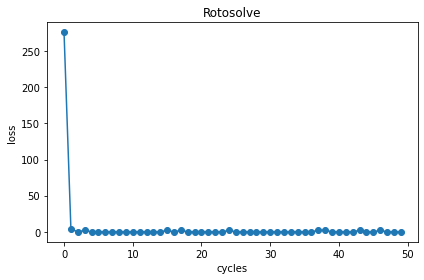

In [6]:
np.random.seed(1)
init_params = list(get_truncated_normal(0,1,-np.pi,np.pi).rvs(4))
params_rsol, costs = fit(init_params, 50)
plot_loss(50, costs, "Rotosolve")

In [7]:
# Now we can verify the if parameters actually work 
print(params_rsol)
m = circuit(params_rsol)
np.unique(m[0] + m[1])

[tensor(-1.57079633, requires_grad=True), tensor(-0.01875397, requires_grad=True), tensor(3.13763228, requires_grad=True), tensor(-0.02399539, requires_grad=True)]


tensor([0, 2], requires_grad=True)

In [8]:
def peek(dev=dev):
    # Take a peek at the wavefunctions (only available in simulation; not possible in real worldj)
    for i,j in enumerate(dev.state):
        print("\psi_{} = {}".format(i,j), end="\t")
        print("\prob_{} = {}".format(i,abs(j)**2))

In [9]:
peek()

\psi_0 = (0.009883100524255232+0.006629785082789052j)	\prob_0 = 0.00014162972621650628
\psi_1 = (-9.26764057236464e-05-0.7070066206796563j)	\prob_1 = 0.49985837027378344
\psi_2 = (0.7070066206796561-9.267640572364642e-05j)	\prob_2 = 0.49985837027378344
\psi_3 = (-0.006629785082789051+0.009883100524255234j)	\prob_3 = 0.0001416297262165063


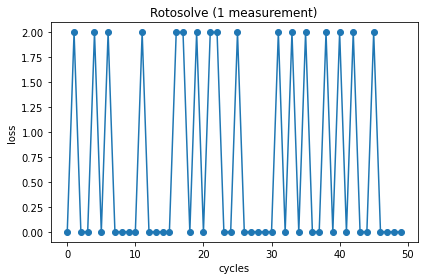

[tensor(0., requires_grad=True), tensor(2.35619449, requires_grad=True), tensor(-0.78539816, requires_grad=True), tensor(0.78539816, requires_grad=True)]
\psi_0 = (0.3266407412190942+0.32664074121909414j)	\prob_0 = 0.2133883476483185
\psi_1 = (0.7885805074747375+0.13529902503654928j)	\prob_1 = 0.6401650429449554
\psi_2 = (0.13529902503654928+0.13529902503654925j)	\prob_2 = 0.036611652351681574
\psi_3 = (0.32664074121909414+0.05604269114599565j)	\prob_3 = 0.10983495705504469


In [10]:
# Now we explore how the number of measurements can affect our algorithm
# 1 measurement per step
params_rsol, costs = fit(init_params, 50, 1)
plot_loss(50, costs, "Rotosolve (1 measurement)")
print(params_rsol)
m = circuit(params_rsol)
peek()

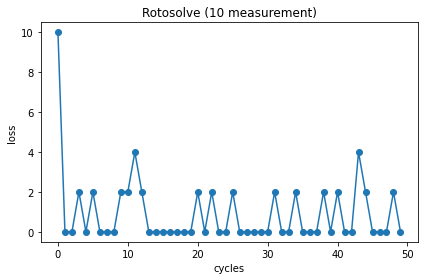

[tensor(-1.32581766, requires_grad=True), tensor(0., requires_grad=True), tensor(1.76819189, requires_grad=True), tensor(1.19028995, requires_grad=True)]
\psi_0 = (0.14697956126571565+0j)	\prob_0 = 0.021602991429862262
\psi_1 = -0.7234879014062656j	\prob_1 = 0.5234347434812423
\psi_2 = (0.6742510169531917+0j)	\prob_2 = 0.4546144338624132
\psi_3 = -0.018650233952484108j	\prob_3 = 0.000347831226482391


In [11]:
# 10 measurement per step
params_rsol, costs = fit(init_params, 50, 10)
plot_loss(50, costs, "Rotosolve (10 measurement)")
print(params_rsol)
q = circuit(params_rsol)
peek()

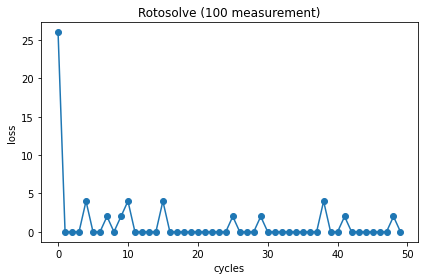

[tensor(-1.57079633, requires_grad=True), tensor(0., requires_grad=True), tensor(-3.10315006, requires_grad=True), tensor(-0.07827114, requires_grad=True)]
\psi_0 = (-0.014080588352557117+0j)	\prob_0 = 0.00019826296835416714
\psi_1 = 0.706966574196861j	\prob_1 = 0.4998017370316458
\psi_2 = (-0.7069665741968609+0j)	\prob_2 = 0.49980173703164565
\psi_3 = -0.014080588352557126j	\prob_3 = 0.00019826296835416738


In [16]:
# 100 measurement per step
params_rsol, costs = fit(init_params, 50, 100)
plot_loss(50, costs, "Rotosolve (100 measurement)")
print(params_rsol)
q = circuit(params_rsol)
peek()

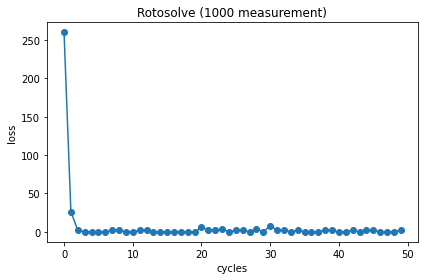

[tensor(-1.57079633, requires_grad=True), tensor(0.04421894, requires_grad=True), tensor(-3.09163426, requires_grad=True), tensor(-0.03680508, requires_grad=True)]
\psi_0 = (0.004649230151100987+0.01563214597524171j)	\prob_0 = 0.0002659793287891721
\psi_1 = (0.0001028087772754123+0.7069186729048584j)	\prob_1 = 0.4997340206712109
\psi_2 = (-0.7069186729048583+0.0001028087772754123j)	\prob_2 = 0.49973402067121075
\psi_3 = (-0.01563214597524171+0.004649230151100981j)	\prob_3 = 0.0002659793287891721


In [14]:
# 1000 measurement per step
params_rsol, costs = fit(init_params, 50, 1000)
plot_loss(50, costs, "Rotosolve (1000 measurement)")
print(params_rsol)
q = circuit(params_rsol)
np.unique(q[0] + q[1])
peek()

The more mesurements taken per step during the optimization, the easier it is for the optimization to converge as the loss function tends to be stable after a few steps. The results also seems to be more accurate with more measurements.